### Imports and config

In [1]:
# Libraries
import os
from importlib import reload
import keras

# Scripts
from helpers import data, runners, utils

In [2]:
# Should be v2.10
!pip show tensorflow 

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
# Should be v2.10
!pip show keras 

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [4]:
reload(data)
reload(runners)
reload(utils)

<module 'helpers.utils' from 'c:\\Users\\sonar\\Desktop\\thesis-ml\\ml\\main\\helpers\\utils.py'>

In [5]:
# Silence information messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 


GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

### Load data

In [6]:
NUM_FOLDS = 10
NUM_EPOCHS = 3
INPUT_SHAPE = (192, 192, 1)
GPU_BATCH_SIZE = 16
DATA_BATCH_SIZE = 16

In [7]:
fold_dfs = data.get_fold_dfs(
    fold_definition_csv='../data/DATASET_CSVS/deepship_5k_seg_3s.csv',
    new_path_to_root='../data/deepship_baseline_detrended_mat/alpha_e0',
    ext='mat',
    unix=False,
    label_encodings={0:'Tanker', 1:'Cargo', 2:'Tug', 3:'Passengership'},
    n_folds=NUM_FOLDS
)
print('Successfully loaded folds.\n')

Successfully loaded folds.



In [8]:
total_samples = 0
for fold_df in fold_dfs:
    total_samples += len(fold_df)
print(total_samples)

53502


### Initialise and configure model

In [9]:
from models import cnn_lstm

cnn_lstm_model = cnn_lstm.get_cnn_lstm(
    input_shape=INPUT_SHAPE,
    input_name='spec',
    num_classes=4,
    verbose=True
)

cnn_lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['acc']
)

Model: "cnn_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spec (InputLayer)           [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 128)     3328      
                                                                 
 batch_normalization (BatchN  (None, 192, 192, 128)    512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 192, 192, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 128)       409

In [10]:
# These are kwargs for Model.fit() and Model.evaluate() excluding x and y.
fit_kwargs = {
    'epochs': NUM_EPOCHS,
    'batch_size': GPU_BATCH_SIZE,
    'verbose': 1,
    'callbacks': [cnn_lstm.callback_early_stop(patience=3, restore_best_weights=True)]
}

eval_kwargs = {
    'batch_size': GPU_BATCH_SIZE,
    'verbose': 1
}

### Run k-fold cross val

In [11]:
reload(runners)

# [DBS = GBS = 8] 5 folds, 3 epochs = 100 - 160 min
# [DBS = GBS = 16] 5 folds, 3 epochs = 80 - 100 min
# [DBS = GBS = 16] 10 folds, 3 epochs = 450 - 500 min

model, histories, evals, metrics = runners.k_fold_cross_validation(
    fold_dfs=fold_dfs,
    model=cnn_lstm_model,
    fit_kwargs=fit_kwargs,
    eval_kwargs=eval_kwargs,
    ext="mat",
    mat_var_name="ampls_detrended_exp",
    data_batch_size=DATA_BATCH_SIZE,
    use_cpu=False
)

FOLD 1
Epoch 1/3
2716/2716 [==============================] - 527s 191ms/step - loss: 0.9148 - acc: 0.6158 - val_loss: 0.8471 - val_acc: 0.6491
Epoch 2/3
2716/2716 [==============================] - 752s 277ms/step - loss: 0.5937 - acc: 0.7685 - val_loss: 0.8401 - val_acc: 0.6702
Epoch 3/3
1/1 [==============================] - 0s 17ms/step
FOLD 2
Epoch 1/3
2666/2666 [==============================] - 853s 320ms/step - loss: 0.2921 - acc: 0.9052 - val_loss: 0.4080 - val_acc: 0.8343
Epoch 2/3
2666/2666 [==============================] - 857s 322ms/step - loss: 0.1443 - acc: 0.9641 - val_loss: 0.8359 - val_acc: 0.7055
Epoch 3/3
1/1 [==============================] - 0s 18ms/step
FOLD 3
Epoch 1/3
2527/2527 [==============================] - 809s 320ms/step - loss: 0.1540 - acc: 0.9533 - val_loss: 1.1397 - val_acc: 0.6695
Epoch 2/3
2527/2527 [==============================] - 771s 305ms/step - loss: 0.0413 - acc: 0.9918 - val_loss: 0.5110 - val_acc: 0.8160
Epoch 3/3
1/1 [==================

In [12]:
# model.save('models/saved/cnn_lstm_baseline_12112024/cnn_lstm_baseline_3_epochs.keras')
# model.save('models/saved/cnn_lstm_detrended_12112024/alpha_e0/cnn_lstm_alpha_e0_3_epochs.keras')
model.save('models/saved/cnn_lstm_detrended_18112024/alpha_e0/cnn_lstm_alpha_e0_3_epochs.keras')
# model.save('models/saved/cnn_lstm_detrended_18112024/alpha_e-2/cnn_lstm_alpha_e-2_3_epochs.keras')
# model.save('models/saved/cnn_lstm_unnorm_17112024/cnn_lstm_unnorm_3_epochs.keras')

### Calculate metrics

In [13]:
evals

[[1.1398355960845947, 0.5700088143348694],
 [2.526496648788452, 0.46465015411376953],
 [1.3905657529830933, 0.660097599029541],
 [0.7665444016456604, 0.7765819430351257],
 [0.10598161816596985, 0.9593663811683655],
 [0.06987504661083221, 0.974416196346283],
 [0.19753913581371307, 0.9309731125831604],
 [0.10247223824262619, 0.9599999785423279],
 [0.5418934226036072, 0.8642165660858154],
 [0.05610426142811775, 0.9849432110786438]]

In [14]:
loss, acc = utils.calculate_metrics(evals)
print(f"Average loss: {loss}")
print(f"Average accuracy: {acc}")

Average loss: 0.6897308122366667
Average accuracy: 0.8145253956317902


C:\Users\sonar\AppData\Local\Temp\ipykernel_27920\631426820.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


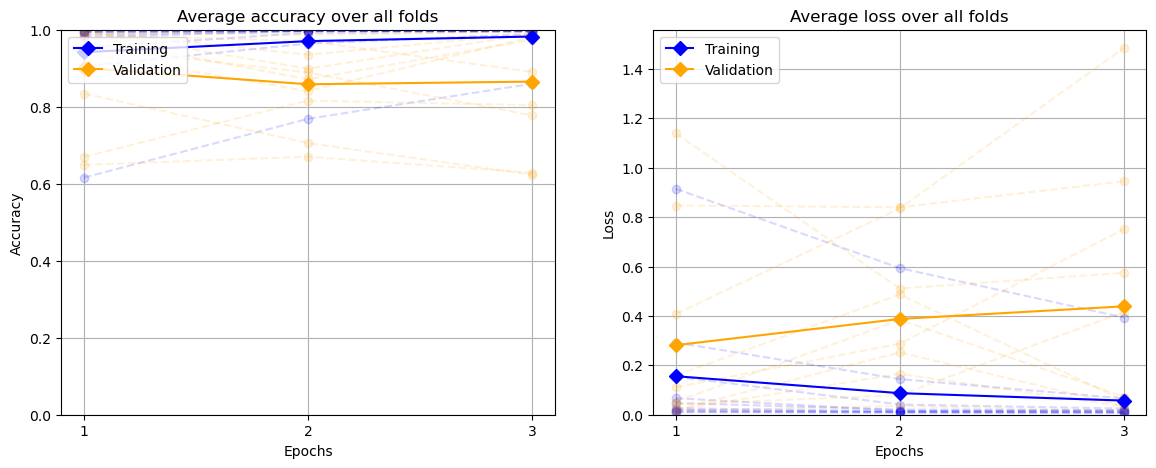

In [15]:
reload(utils)

fig = utils.get_acc_loss_curves_by_epoch(histories, overlay=True)
# fig.savefig('models/saved/cnn_lstm_baseline_12112024/img/3_epochs_by_epoch.pdf')
fig.savefig('models/saved/cnn_lstm_detrended_18112024/alpha_e0/img/3_epochs_by_epoch.pdf')
# fig.savefig('models/saved/cnn_lstm_detrended_18112024/alpha_e-2/img/3_epochs_by_epoch.pdf')
# fig.savefig('models/saved/cnn_lstm_unnorm_17112024/img/3_epochs_by_epoch.pdf')
fig.show()

C:\Users\sonar\AppData\Local\Temp\ipykernel_27920\4116345387.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


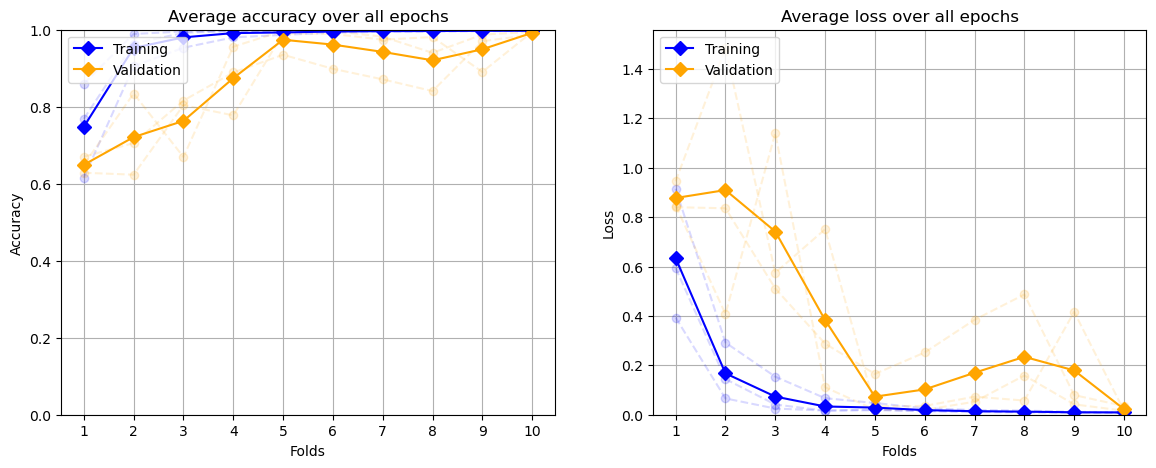

In [16]:
reload(utils)

fig = utils.get_acc_loss_curves_by_fold(histories, overlay=True)
# fig.savefig('models/saved/cnn_lstm_baseline_12112024/img/3_epochs_by_fold.pdf')
fig.savefig('models/saved/cnn_lstm_detrended_18112024/alpha_e0/img/3_epochs_by_fold.pdf')
# fig.savefig('models/saved/cnn_lstm_detrended_18112024/alpha_e-2/img/3_epochs_by_fold.pdf')
# fig.savefig('models/saved/cnn_lstm_unnorm_17112024/img/3_epochs_by_fold.pdf')
fig.show()

In [17]:
print("Average Precision:", metrics["precision"])
print("Average Recall:", metrics["recall"])
print("Average F1 Score:", metrics["f1_score"])
print("Average Accuracy:", metrics["accuracy"])

Average Precision: 0.8540519538988297
Average Recall: 0.8145253959855484
Average F1 Score: 0.807588129345205
Average Accuracy: 0.8145253959855484
